In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import random
import numpy as np
import copy
import pickle
import torch
import learn2learn as l2l
from tqdm import tqdm
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_TTTpaper_fixMask, rss_torch, scale_sensmap
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
from functions.training.losses import SSIMLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

########################### experiment name ###########################
LOSS = 'joint'      # 'sup', 'joint'
DOMAIN = 'P'        # 'P', 'Q'
COIL = 'sensmap'   # 'sensmap'

experiment_name = 'E14.2_maml_out_k-'+LOSS+'(l1_out-5_in-5)'+DOMAIN+'_T300_300epoch'


# tensorboard dir
experiment_path = '/cheng/metaMRI/metaMRI/save/' + experiment_name + '/'
writer = SummaryWriter(experiment_path)

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

###########################  hyperparametes  ###########################
EPOCH = 300   
# enumalate the whole data once takes 180 outer loop
Inner_EPOCH = 1
BATCH_SIZE = 1
adapt_steps = 5
adapt_lr = 0.00001   # adapt θ': α
meta_lr = 0.00001    # update real model θ: β

###########################  data & dataloader  ###########################

# data path
if DOMAIN == 'P': 
    path_train = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_knee_train_300.yaml'
    path_to_train_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_knee_train/'
    path_mask = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/knee_mask'

elif DOMAIN == 'Q':
    path_train = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_train_300.yaml'
    path_to_train_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_train/'
    path_mask = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/brain_mask'


# data transform
data_transform = UnetDataTransform_TTTpaper_fixMask('multicoil')

# training dataset and data loader
trainset = SliceDataset(dataset = path_train, path_to_dataset='', 
                path_to_sensmaps = path_to_train_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, 
                use_dataset_cache=True)

train_dataloader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE,
                shuffle = False, generator = torch.Generator().manual_seed(SEED), pin_memory = True)
print("Training date number: ", len(train_dataloader.dataset))



#%% Check the data 
###########################  model  ###########################
# complex
model = Unet(in_chans = 2,out_chans = 2,chans = 64, num_pool_layers = 4,drop_prob = 0.0)
model = model.to(device)
maml = l2l.algorithms.MAML(model, lr=adapt_lr, first_order=False, allow_unused=True)



###########################  MAML training  ###########################
optimizer = optim.Adam(maml.parameters(), meta_lr)
l1_loss = nn.L1Loss(reduction='sum')

with open(path_mask,'rb') as fn:
    mask2d = pickle.load(fn)
flipped_mask2d = np.logical_not(mask2d).astype(int)
mask = torch.tensor(mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
flipped_mask = torch.tensor(flipped_mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
mask = mask.to(device)
flipped_mask = flipped_mask.to(device)

Training date number:  300


In [2]:
iter = iter(train_dataloader)
batch = next(iter)

In [3]:
kspace, sens_maps, sens_maps_conj, _, fname, slice_num = batch
kspace = kspace.squeeze(0).to(device)
sens_maps = sens_maps.squeeze(0).to(device)
sens_maps_conj = sens_maps_conj.squeeze(0).to(device)

In [4]:
input_kspace = kspace * mask + 0.0
train_inputs = complex_abs(complex_mul(ifft2c(input_kspace), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)

In [5]:
ground_truth = complex_abs(complex_mul(ifft2c(kspace), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)

In [6]:
unused_kspace = kspace * flipped_mask + 0.0
train_target = complex_abs(complex_mul(ifft2c(unused_kspace), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)

In [7]:
train_target.shape

torch.Size([1, 640, 372])

In [8]:
target_image_1c = complex_abs(complex_mul(ifft2c(kspace ), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)

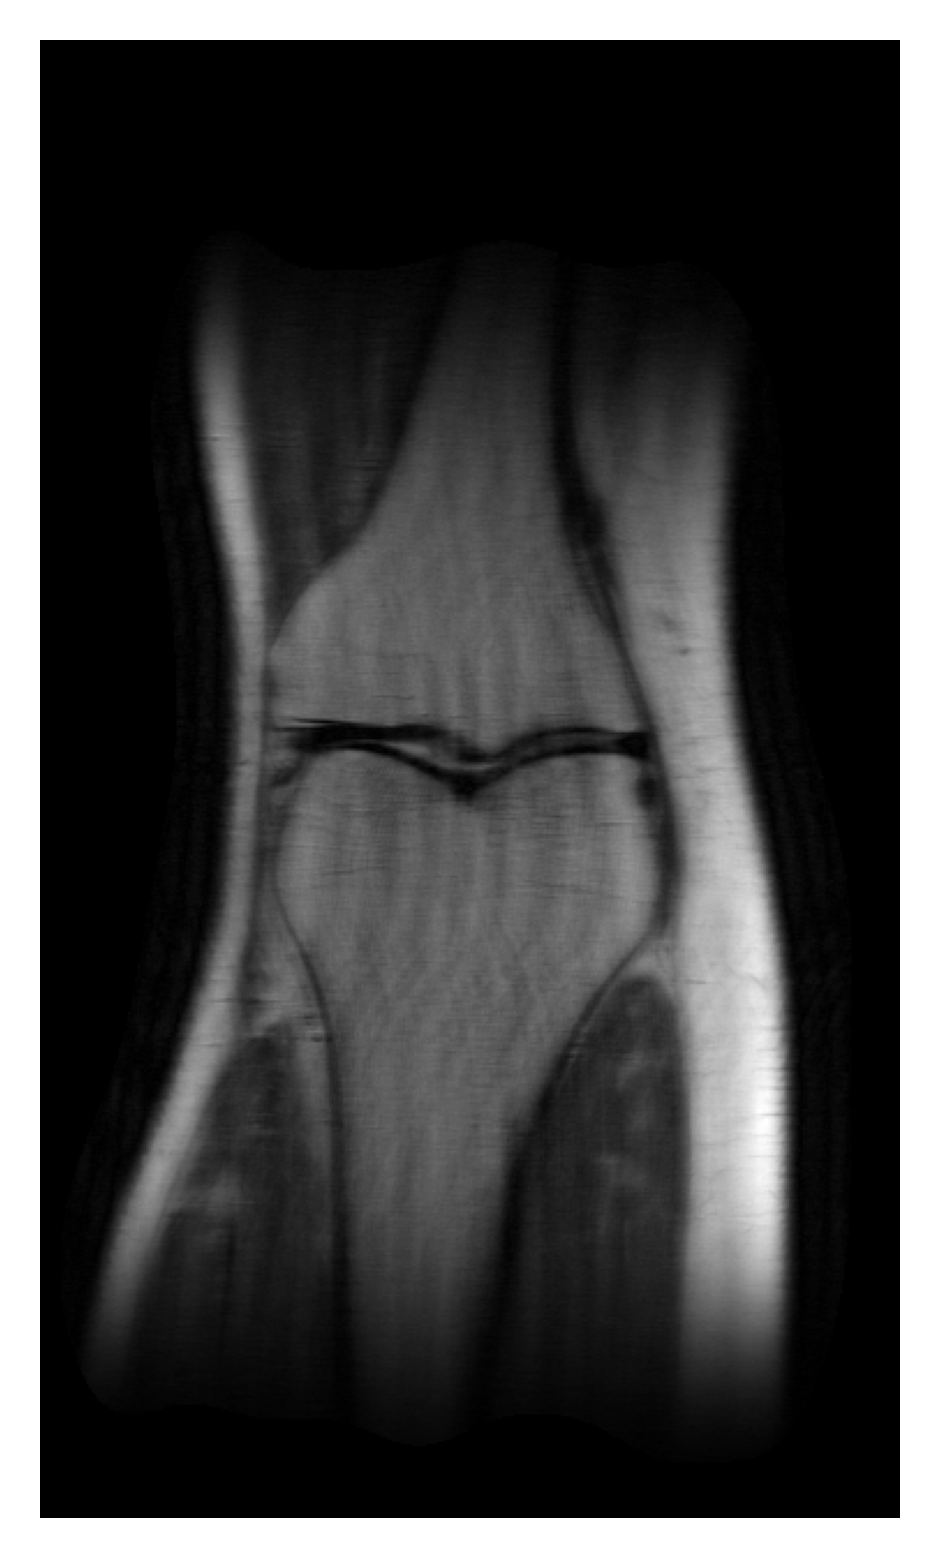

In [7]:
import matplotlib.pyplot as plt
plt.figure(dpi=400)
plt.imshow(train_inputs.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

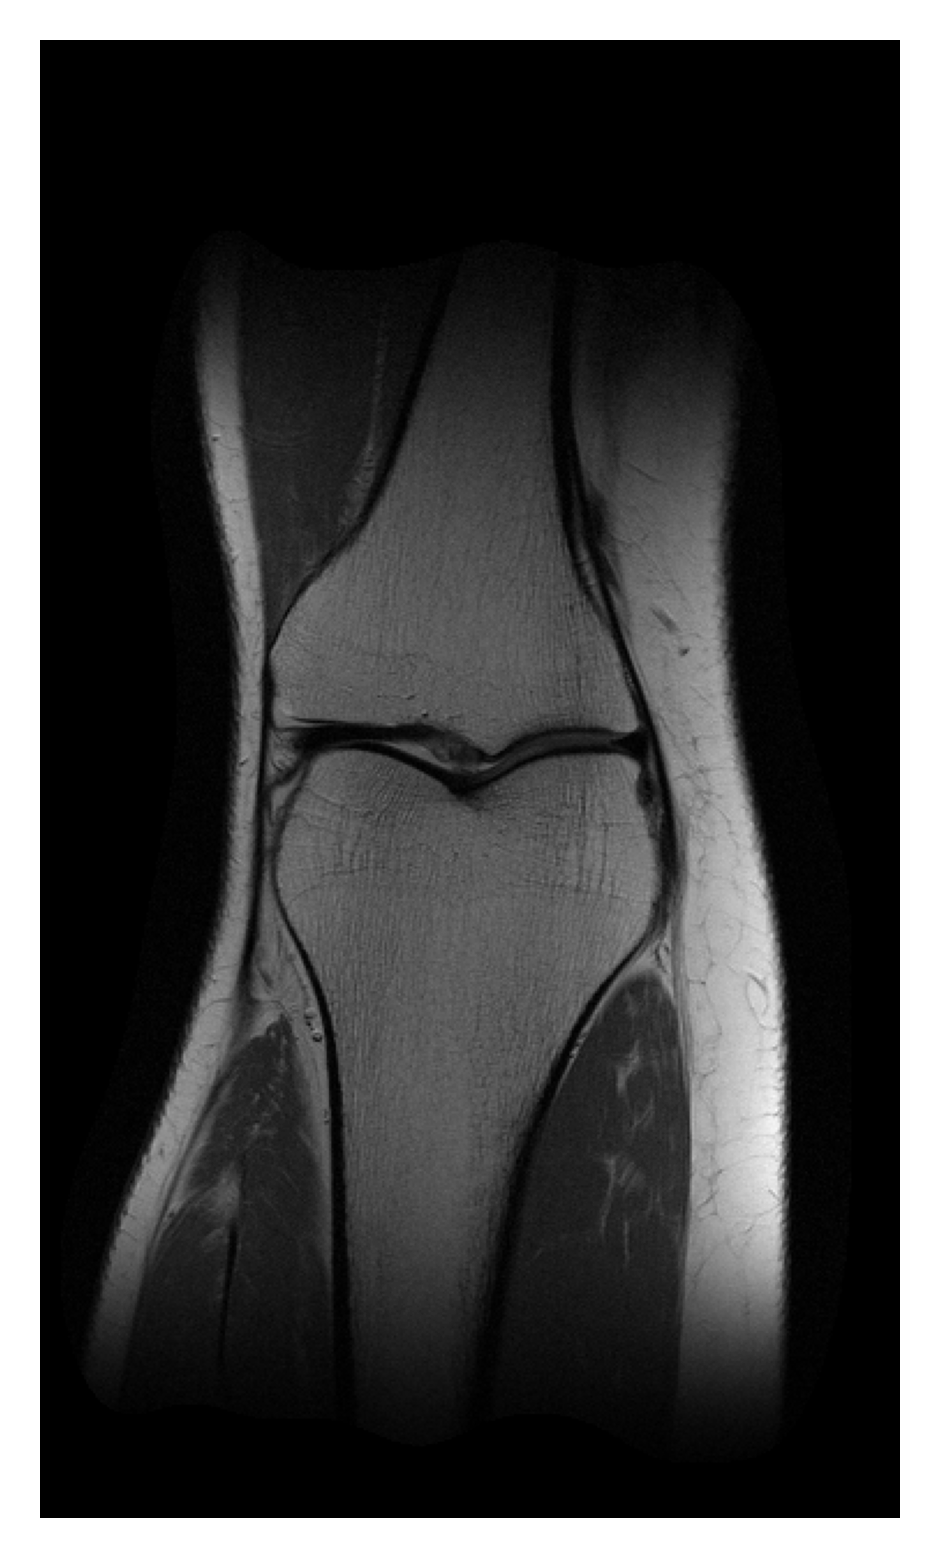

In [9]:
import matplotlib.pyplot as plt
plt.figure(dpi=400)
plt.imshow(target_image_1c.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

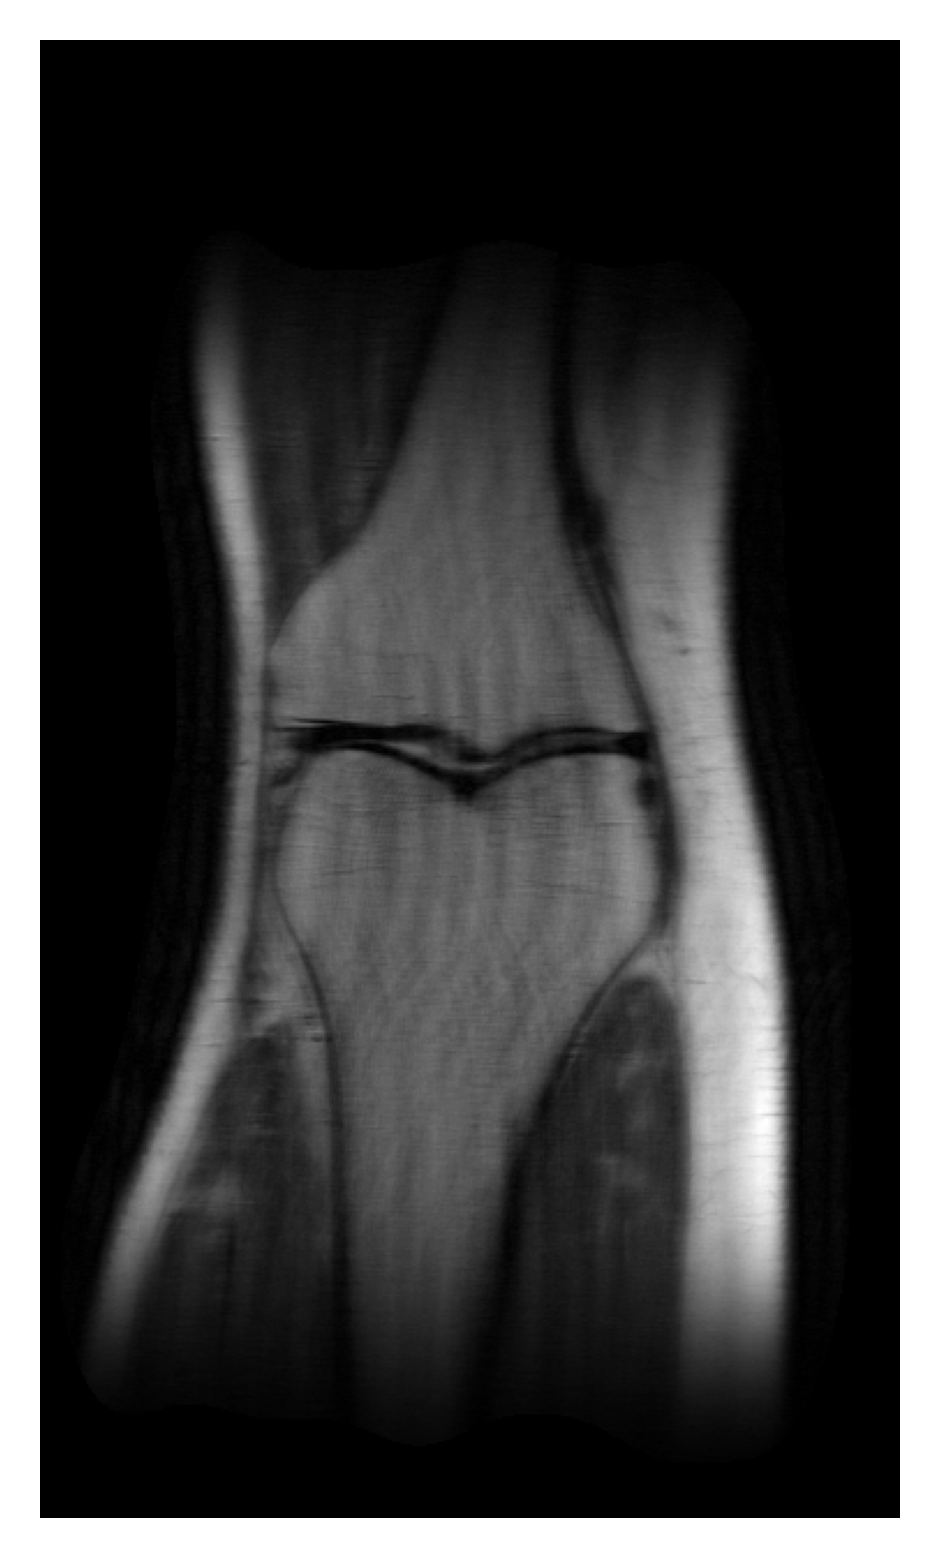

In [10]:
import matplotlib.pyplot as plt
plt.figure(dpi=400)
plt.imshow(train_inputs.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

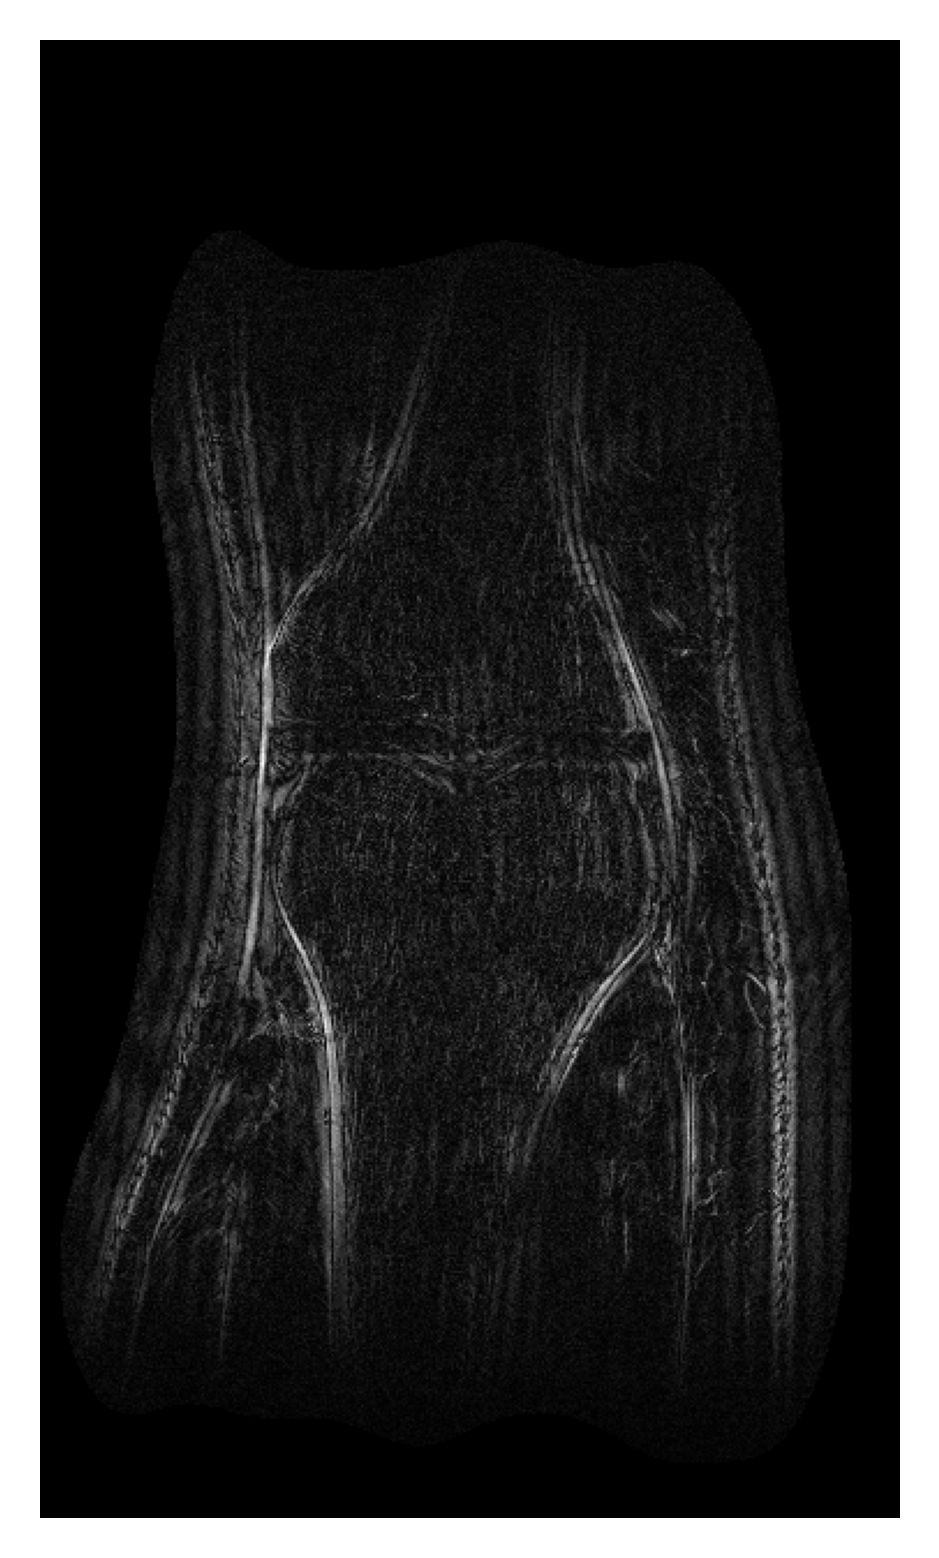

In [11]:
plt.figure(dpi=400)
plt.imshow(train_target.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()